In [1]:
import re
from collections import defaultdict

import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier

from IPython.core.display import display, HTML


In [2]:
with open('../../data/clean/misconduct_lobbying_indicators_train.pkl', 'rb') as train_file:
    misconduct = pickle.load(train_file)

In [3]:
indicated_cols = [
    'misconduct_type',
    'court_type',
    'enforcement_agency',
    'contracting_party'
]

indicator_features = [
    col for col in misconduct.columns
    if re.search(f'^({"|".join(indicated_cols)})_', col)
]

In [4]:
misconduct_train, misconduct_validate = train_test_split(misconduct, test_size=0.2)

In [5]:
# ​

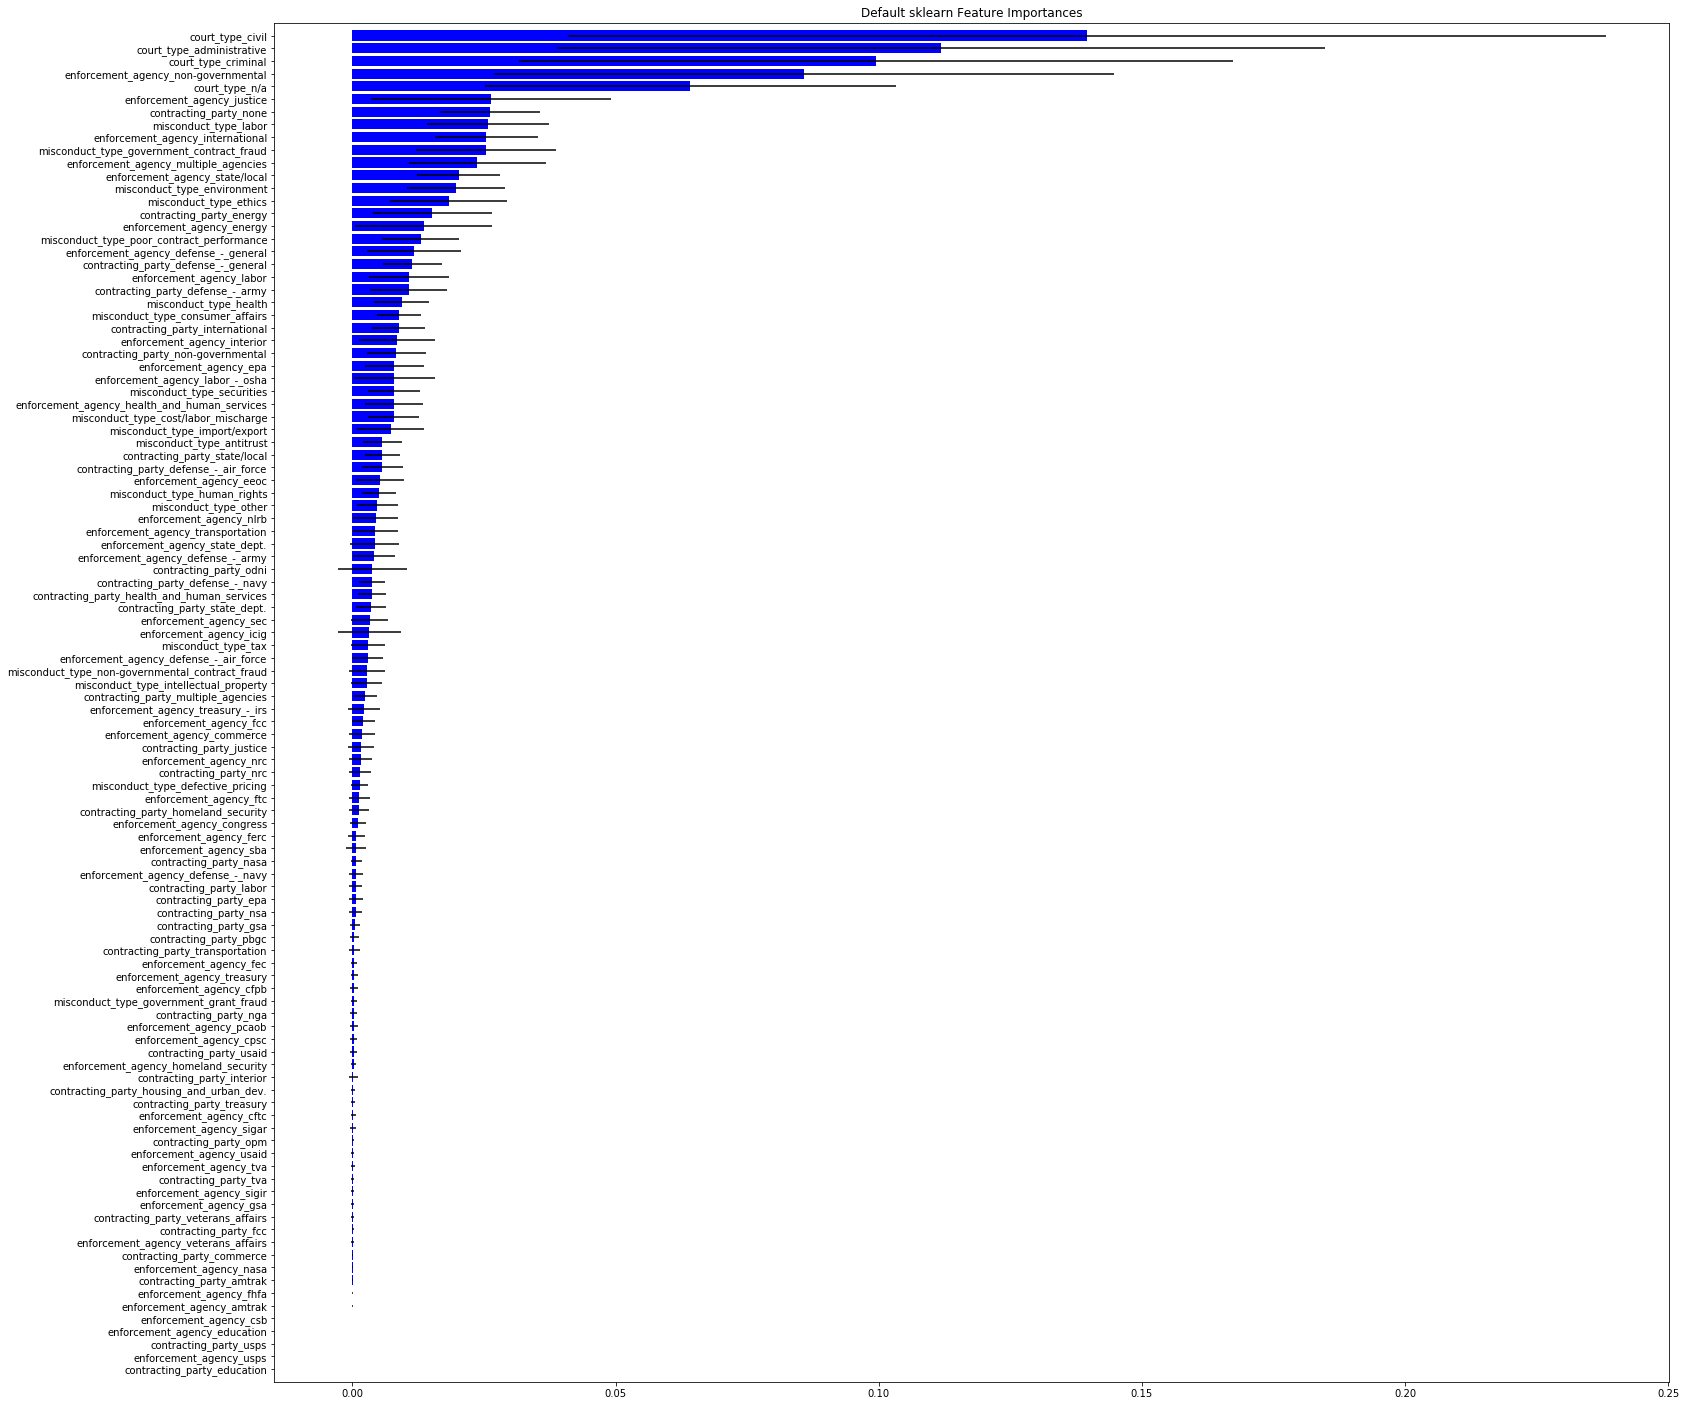

In [6]:
random_forest_model = RandomForestClassifier(
    n_estimators=76, # entropy more uniform, gini needed at least ~60
    max_depth=16, # too high? but cross validation works
    criterion='entropy', # mot much difference
    random_state=62
)
X = misconduct_train.loc[:, indicator_features]
random_forest_model.fit(
    X,
    misconduct_train['disposition_type']
)

importances = random_forest_model.feature_importances_
std = np.std(
    [tree.feature_importances_ for tree in random_forest_model.estimators_],
    axis=0
)
indices = np.argsort(importances)

plt.figure(figsize=(25, 25))
plt.title("Default sklearn Feature Importances")
plt.barh(
    range(X.shape[1]),
    importances[indices],
    color="b",
    xerr=std[indices],
    align="center"
)

plt.yticks(range(X.shape[1]), [X.columns[i] for i in indices])
plt.ylim([-1, X.shape[1]])

plt.savefig('importances.png')
# plt.scatter(
#     random_forest_model.feature_importances_
# )


In [7]:
def scores(model):
    model.fit(
        misconduct_train.loc[:, indicator_features],
        misconduct_train['disposition_type']
    )
    predictions = model.predict(
        misconduct_validate.loc[:, indicator_features],
    )
    
    represented_labels = list(
        set(misconduct_validate['disposition_type']) &
        set(np.unique(predictions))
    )
    
    return classification_report(
        misconduct_validate['disposition_type'],
        predictions,
        labels=represented_labels, # no predications ruins scores
        output_dict=True
    )['macro avg']

In [8]:
def add_scores(all_scores, model_name, model_scores):
    for score_name, score in model_scores.items():
        all_scores[score_name][model_name] = score
    

In [9]:
all_scores = defaultdict(dict)

In [10]:
# n_neighbors
#     accuracy peaked at ~10 and ~30
#     ~30 barely lower and less variance in region
# p not important because the features are binary
add_scores(
    all_scores,
    'KNN',
    scores(
        KNeighborsClassifier(p=1, weights='distance', n_neighbors=30)
    )
)

In [11]:
add_scores(
    all_scores,
    'naive_bayes_bern',
    scores(
        BernoulliNB()
    )
)

In [12]:
add_scores(
    all_scores,
    'logistic_regression',
    scores(
        LogisticRegression(solver='sag', multi_class='auto')
    )
)


In [13]:
add_scores(
    all_scores,
    'svc_linear',
    scores(
        SVC(kernel='linear')
    )
)


In [14]:
add_scores(
    all_scores,
    'svc_rbf',
    scores(
        SVC(kernel='rbf', gamma='auto')
    )
)


In [15]:
add_scores(
    all_scores,
    'svc_poly',
    scores(
        SVC(kernel='poly', gamma='auto')
    )
)


In [16]:
add_scores(
    all_scores,
    'svc_sigmoid',
    scores(
        SVC(kernel='sigmoid', gamma='auto')
    )
)


In [17]:
add_scores(
    all_scores,
    'decision_tree',
    scores(
        DecisionTreeClassifier()
    )
)


In [18]:
add_scores(
    all_scores,
    'random_forest',
    scores(
        RandomForestClassifier(
            n_estimators=76, # entropy more uniform, gini needed at least ~60
            max_depth=16, # too high? but cross validation works
            criterion='entropy', # mot much difference
            random_state=62
        )
    )
)


In [19]:
# cat_boost_model = CatBoostClassifier(
#     iterations=2,
#     depth=2,
#     learning_rate=1,
#     loss_function='Logloss',
#     logging_level='Verbose'
# )

# cat_boost_model.fit(
#     misconduct_train.loc[:, indicator_features],
#     misconduct_train['disposition_type']
# )

# predictions = cat_boost_model.predict(
#     misconduct_validate.loc[:, indicator_features],
# )

# represented_labels = list(
#     set(misconduct_validate['disposition_type']) &
#     set(np.unique(predictions))
# )

# add_scores(
#     all_scores,
#     'cat_boost',
#     classification_report(
#         misconduct_validate['disposition_type'],
#         predictions,
#         labels=represented_labels, # no predications ruins scores
#         output_dict=True
#     )['macro avg']
# )


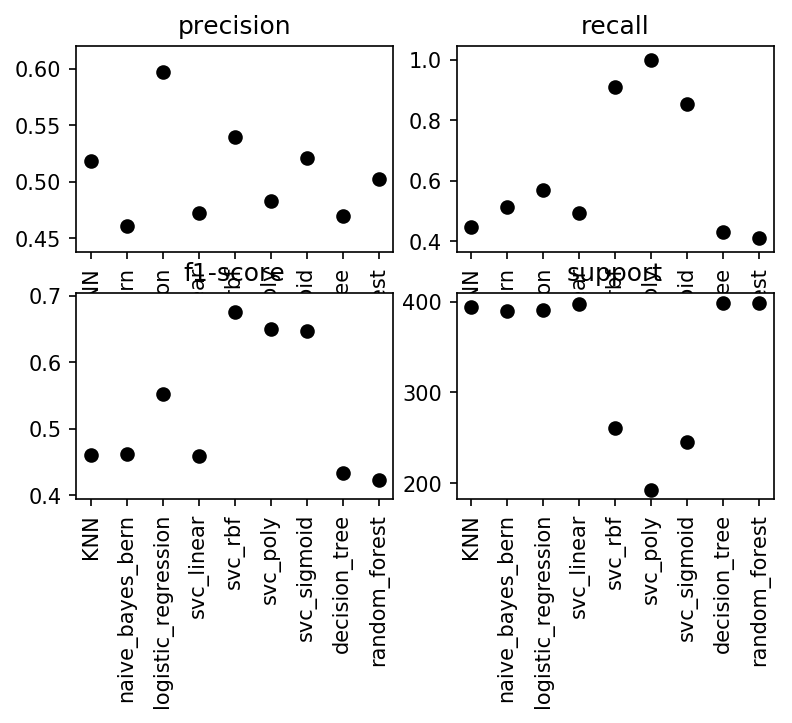

In [20]:
plt.figure(dpi=150)

for score_ind, (score_name, scores) in enumerate(all_scores.items()):
    plt.subplot(2, 2, score_ind + 1)
    model_names = list(scores.keys())
    model_scores = list(scores.values())

    plt.scatter(
        model_names,
        model_scores,
        color='#000000'
    )
    plt.title(score_name)
    plt.xticks(rotation='vertical')
#         plt.annotate(f'{model_name}', (model_names[ind], ind))

In [21]:
for model, f1 in all_scores['f1-score'].items():
    print(f'{model}: {round(f1, 3)}')

KNN: 0.46
naive_bayes_bern: 0.462
logistic_regression: 0.552
svc_linear: 0.458
svc_rbf: 0.676
svc_poly: 0.651
svc_sigmoid: 0.647
decision_tree: 0.433
random_forest: 0.423


([0, 1, 2, 3, 4, 5, 6, 7, 8], <a list of 9 Text xticklabel objects>)

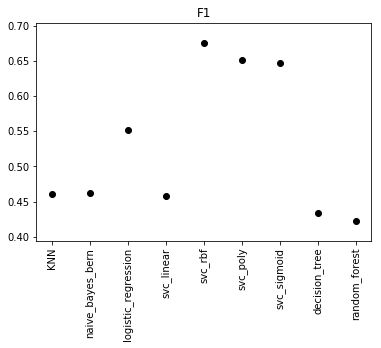

In [22]:
plt.scatter(
    all_scores['f1-score'].keys(),
    all_scores['f1-score'].values(),
    color='#000000'
)
plt.title('F1')
plt.xticks(rotation='vertical')

Text(0.5, 1.0, 'F1')

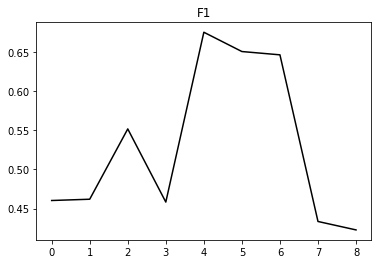

In [23]:
plt.plot(
    all_scores['f1-score'].values(),
    color='#000000'
)
plt.title('F1')
# plt.xticks(rotation='vertical')